# Look at relationship b/n mean state quantities and RO parameters

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import warnings
import tqdm
import pathlib
import cmocean
import os

# Import custom modules
import src.utils
from src.XRO import XRO, xcorr

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def get_zonal_grad(x):
    """
    Function to compute zonal gradient. Ref: Fig 7 in Maher et al, 2023.
    """

    ## outlines for boxes
    ebox_coords = dict(longitude=slice(210, 270), latitude=slice(-5, 5))
    wbox_coords = dict(longitude=slice(120, 180), latitude=slice(-5, 5))

    ## compute box averages
    ebox_avg = src.utils.spatial_avg(x.sel(ebox_coords))
    wbox_avg = src.utils.spatial_avg(x.sel(wbox_coords))

    return ebox_avg - wbox_avg

## Load $T,h$ data

In [3]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

## Fit RO to $T,h$ data

In [4]:
## get subset of data
Th_sub = Th.sel(time=slice("1979", "2024"))

## initialize model
model = XRO(ncycle=12, ac_order=3, is_forward=True)

## fit to individual ensemble members
kwargs = dict(model=model, T_var="T_3", h_var="h_w", verbose=True)
_, fits = src.utils.get_RO_ensemble(Th_sub, **kwargs)

## extract parameters
params = model.get_RO_parameters(fits)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.78it/s]


## Load spatial data

In [5]:
## Load EOF data
eofs_fp = pathlib.Path(DATA_FP, "mpi", "eofs")
eofs = src.utils.load_eofs(eofs_fp / "ts.nc")

## for convenience, put PC data into single dataset
pc_data = eofs.scores().rename("sst")

## estimate forced signal
forced = pc_data.mean("member")
anom = pc_data - forced

### Compute zonal gradient

In [6]:
## get subset of data to look at
anom_ = anom.sel(time=slice("1979", "2024"))

## compute zonal gradient at every time step
zonal_grad = src.utils.reconstruct_fn(eofs.components(), anom_, fn=get_zonal_grad)

## get monthly avg
zonal_grad_by_month = zonal_grad.groupby("time.month").mean()

## Look at relation

### Look at intra-ensemble spread

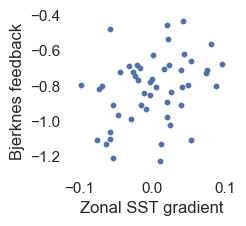

In [7]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(zonal_grad_by_month.mean("month"), params["R"].mean("cycle"), s=10)
# ax.scatter(zonal_grad_by_month.sel(month=7), params["R"].sel(cycle=7), s=10)
ax.set_xlabel("Zonal SST gradient")
ax.set_ylabel("Bjerknes feedback")
plt.show()

### Look at forced change

In [8]:
## compute zonal gradient
zonal_grad_forced = src.utils.reconstruct_fn(
    eofs.components(), forced, fn=get_zonal_grad
)

## reshape from time -> (month, year)
reshape = lambda x: x.reshape(12, -1, order="F")
zonal_grad_forced_by_month = reshape(zonal_grad_forced.values)

## subtract clim
clim = zonal_grad_forced_by_month[:, :30].mean(1, keepdims=True)
zonal_grad_change = zonal_grad_forced_by_month - clim

## get month, year dims
month = np.unique(forced.time.dt.month.values)
year = np.unique(forced.time.dt.year)

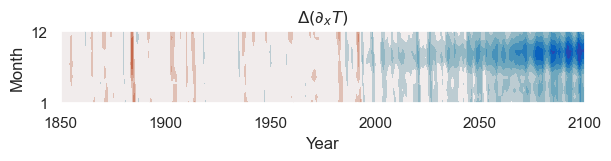

In [9]:
## specify levels for plotting
levels = src.utils.make_cb_range(1, 0.1)

## setup plot
fig, ax = plt.subplots(figsize=(6, 1.5), layout="constrained")

## plot data
kwargs = dict(levels=src.utils.make_cb_range(1, 0.1), cmap="cmo.balance")
plot_data = ax.contourf(year, month, zonal_grad_change, **kwargs)

## label
ax.set_xlabel("Year")
ax.set_ylabel("Month")
ax.set_yticks([1, 12])
ax.set_title(r"$\Delta \left(\partial_x T\right)$")

plt.show()